## Fundamentals of clustering on a real dataset. ##

### The dataset ###

For the clustering problem, we will use the famous Zachary’s Karate Club dataset. The story behind the data set is quite simple: There was a Karate Club that had an administrator “John A” and an instructor “Mr. Hi” (both pseudonyms). Then a conflict arose between them, causing the students (Nodes) to split into two groups. One that followed John and one that followed Mr. Hi.

In [1]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

### Visualization on our data ###

What that function does is to simply extract the number of clusters that are in our result and then assign a different color to each of them (up to 10 for the given time is fine) before plotting them.

In [2]:
def drawCommunities(G, partition, pos):
    # G is graph in networkx form
    # Partition is a dict containing info on clusters
    # Pos is base on networkx spring layout (nx.spring_layout(G))

    # For separating communities colors
    dictList = defaultdict(list)
    nodelist = []
    for node, com in partition.items():
        dictList[com].append(node)

    # Get size of Communities
    size = len(set(partition.values()))

    # For loop to assign communities colors
    for i in range(size):

        amplifier = i % 3
        multi = (i / 3) * 0.3

        red = green = blue = 0

        if amplifier == 0:
            red = 0.1 + multi
        elif amplifier == 1:
            green = 0.1 + multi
        else:
            blue = 0.1 + multi

        # Draw Nodes
        nx.draw_networkx_nodes(G, pos,
                               nodelist=dictList[i],
                               node_color=[0.0 + red, 0.0 + green, 0.0 + blue],
                               node_size=500,
                               alpha=0.8)

    # Draw edges and final plot
    plt.title("Zachary's Karate Club")
    nx.draw_networkx_edges(G, pos, alpha=0.5)


In [3]:
def listToDict(list):
    listdict = {}

    for i in range(len(list)):
        listdict[i] = list[i]

    return listdict

The final step of the data preprocessing, is to transform the graph into a matrix (desirable input for our algorithms). This is also quite simple:

In [4]:
def graphToEdgeMatrix(G):
    # Initialize Edge Matrix
    edgeMat = [[0 for x in range(len(G))] for y in range(len(G))]

    # For loop to set 0 or 1 ( diagonal elements are set to 1)
    for node in G:
        tempNeighList = G.neighbors(node)
        for neighbor in tempNeighList:
            edgeMat[node][neighbor] = 1
        edgeMat[node][node] = 1

    return edgeMat

### Getting Started with Clustering in Python ###

In [5]:
# Initialize some variables to help us with the generalization of the program
kClusters = 2
results = []
nmiResults = []
arsResults = []

# Load and Store both data and groundtruth of Zachary's Karate Club
G = nx.karate_club_graph()
groundTruth = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
# Transform our graph data into matrix form
edgeMat = graphToEdgeMatrix(G)

In [7]:
# Positions the nodes using Fruchterman-Reingold force-directed algorithm
# Too technical to discuss right now, just go with it
pos = nx.spring_layout(G)
drawCommunities(G, listToDict(groundTruth), pos)

### Clustering Algorithms ###

### Spectral Clustering Model ###
The Spectral clustering technique applies clustering to a projection of the normalized Laplacian. When it comes to image clustering, spectral clustering works quite well.

In [8]:
# Spectral Clustering Model
spectral = cluster.SpectralClustering(n_clusters=kClusters, affinity="precomputed", n_init=200)
spectral.fit(edgeMat)

# Transform our data to list form and store them in results list
results.append(list(spectral.labels_))

### Agglomerative Clustering Model ###
The main idea behind agglomerative clustering is that each node starts in its own cluster, and recursively merges with the pair of clusters that minimally increases a given linkage distance. The main advantage of agglomerative clustering (and hierarchical clustering in general) is that you don’t need to specify the number of clusters. That of course, comes with a price: performance. But, in scikit’s implementation, you can specify the number of clusters to assist the algorithm’s performance.

In [9]:
# Agglomerative Clustering Model
agglomerative = cluster.AgglomerativeClustering(n_clusters=kClusters, linkage="ward")
agglomerative.fit(edgeMat)

# Transform our data to list form and store them in results list
results.append(list(agglomerative.labels_))

### K-means Clustering Model ###
K-means is considered by many the gold standard when it comes to clustering due to its simplicity and performance.

When you have no idea at all what algorithm to use, K-means is usually the first choice. Bear in mind that K-means might under-perform sometimes due to its concept: spherical clusters that are separable in a way so that the mean value converges towards the cluster center.

In [10]:
# K-means Clustering Model
kmeans = cluster.KMeans(n_clusters=kClusters, n_init=200)
kmeans.fit(edgeMat)

# Transform our data to list form and store them in results list
results.append(list(kmeans.labels_))

### Affinity Propagation Clustering Model ###
Well this one is a bit different. Unlike the previous algorithms, you can see AF does not require the number of clusters to be determined before running the algorithm. AF, performs really well on several computer vision and biology problems, such as clustering pictures of human faces and identifying regulated transcripts:

In [11]:
# Affinity Propagation Clustering Model
affinity = cluster.affinity_propagation(S=edgeMat, max_iter=200, damping=0.6)

# Transform our data to list form and store them in results list
results.append(list(affinity[1]))

# Append the results into lists
for x in results:
    nmiResults.append(normalized_mutual_info_score(groundTruth, x))
    arsResults.append(adjusted_rand_score(groundTruth, x))

### Normalized Mutual Information (NMI) ###

Mutual Information of two random variables is a measure of the mutual dependence between the two variables. Normalized Mutual Information is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation). In other words, 0 means dissimilar and 1 means perfect match.

### Adjusted Rand Score (ARS) ###

Adjusted Rand Score on the other hand, computes a similarity measure between two clusters by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusters. If that's a little weird to think about, have in mind that, for now, 0 is the lowest similarity and 1 is the highest.

So, to get a combination of these metrics (the NMI and ARS), we simply calculate the average value of their sum. And remember, the higher the number, the better the result.

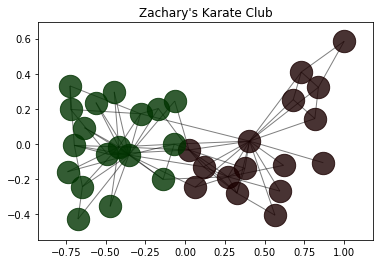

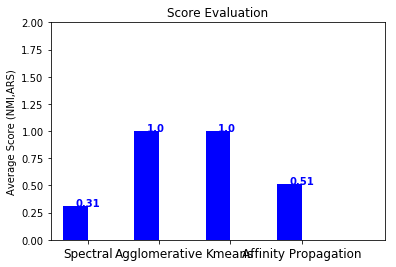

In [12]:
# Code for plotting results

# Average of NMI and ARS
y = [sum(x) / 2 for x in zip(nmiResults, arsResults)]

xlabels = ['Spectral', 'Agglomerative', 'Kmeans', 'Affinity Propagation']

fig = plt.figure()
ax = fig.add_subplot(111)

# Set parameters for plotting
ind = np.arange(len(y))
width = 0.35

# Create barchart and set the axis limits and titles
ax.bar(ind, y, width, color='blue', error_kw=dict(elinewidth=2, ecolor='red'))
ax.set_xlim(-width, len(ind) + width)
ax.set_ylim(0, 2)
ax.set_ylabel('Average Score (NMI,ARS)')
ax.set_title('Score Evaluation')

# Add the xlabels to the chart
ax.set_xticks(ind + width / 2)
xtickNames = ax.set_xticklabels(xlabels)
plt.setp(xtickNames, fontsize=12)

# Add the actual value on top of each chart
for i, v in enumerate(y):
    ax.text(i, v, str(round(v, 2)), color='blue', fontweight='bold')

# Show the final plot
plt.show()

As you can see in the chart above, K-means and Agglomerative clustering have the best results for our dataset (best possible outcome). That of course, does not mean that Spectral and AF are low-performing algorithms, just that the did not fit in our data.